# Analyzing a synthetized mrw

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
figure_folder = 'figures/fBm/'

## Generating a signal

Let's first generate a multifractal random walk with parameters H = 0.8, $\lambda$ = 0.3 and L = 4096

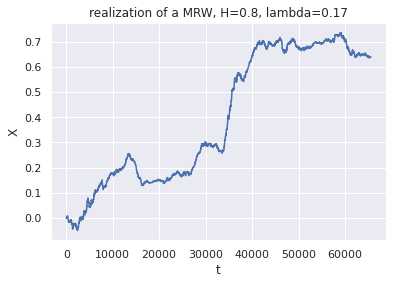

In [3]:
from pymultifracs.simul import mrw
import numpy as np

X = mrw(shape=65536, H=0.8, lam=np.sqrt(0.03), L=65536)

plt.plot(X)
plt.title('realization of a MRW, H=0.8, lambda=0.17')
plt.ylabel('X')
plt.xlabel('t')
plt.show()

In [4]:
X = np.diff(X)

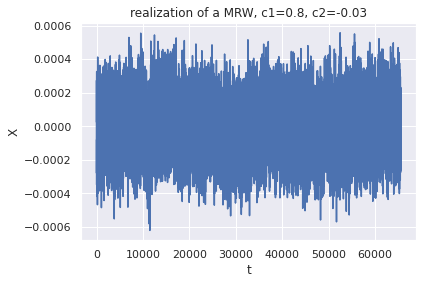

In [5]:
from pymultifracs.simul import mrw_cumul

X2 = mrw_cumul(shape=65536, c1=0.8, c2=-0.00000003, L=65536)
X2 = np.diff(X2)

plt.plot(X2)
plt.title('realization of a MRW, c1=0.8, c2=-0.03')
plt.ylabel('X')
plt.xlabel('t')
plt.show()

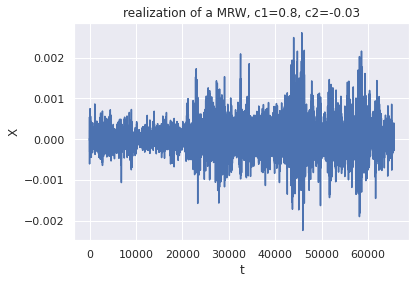

In [6]:
from pymultifracs.simul import mrw_cumul

X2 = mrw_cumul(shape=65536, c1=0.8, c2=-0.03, L=65536)
X2 = np.diff(X2)

plt.plot(X2)
plt.title('realization of a MRW, c1=0.8, c2=-0.03')
plt.ylabel('X')
plt.xlabel('t')
plt.show()

## Power Spectral Density

Power spectral density analysis is done with the `psd` module

The sampling frequency `fs` is necessary in order to correctly label the frequency axis

In [7]:
import pymultifracs.psd as psd

fs = 1

The Fourier-based PSD estimation is done using the Welch estimator.

The arguments relative the Fourier-based estimation are:
* `n_fft`: length of the FFT used
* `seg_size`: size of the segment used in the Welch estimation

In [8]:
from importlib import reload

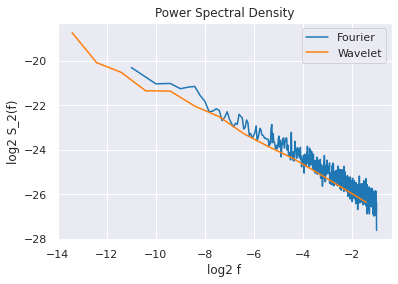

In [9]:
psd.plot_psd(X, fs, n_fft=2048)

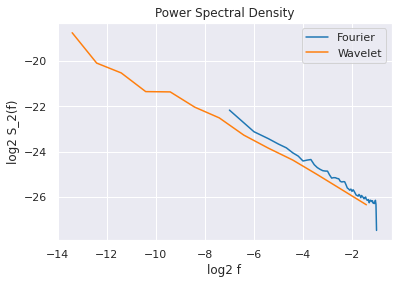

In [10]:
psd.plot_psd(X, fs, n_fft=128)

The Wavelet-based estimation is done using wavelet analysis based on the Daubechies wavelet.

The number of vanishing moments can be controlled using the `n_moments` argument

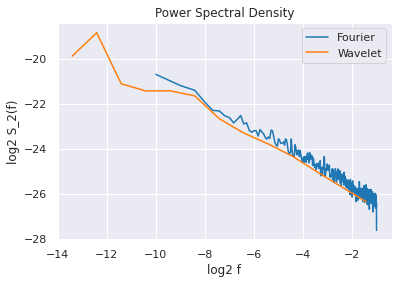

In [11]:
psd.plot_psd(X, fs, n_moments=3, n_fft=1024)

The wavelet-based estimation of the PSD is obtained via the `wavelet_estimation` function

In [12]:
PSD = psd.wavelet_estimation(X, fs, n_moments=3)

The output is an instance of the `PSD` namedtuple, with two fields: `freq` which contains the frequency support of the PSD estimation, and `psd` which contains the actual power estimates

In [13]:
PSD.freq, PSD.psd

(array([3.75000000e-01, 1.87500000e-01, 9.37500000e-02, 4.68750000e-02,
        2.34375000e-02, 1.17187500e-02, 5.85937500e-03, 2.92968750e-03,
        1.46484375e-03, 7.32421875e-04, 3.66210938e-04, 1.83105469e-04,
        9.15527344e-05]),
 array([[1.15790329e-08],
        [1.82947554e-08],
        [2.89703638e-08],
        [4.69504548e-08],
        [6.88415992e-08],
        [9.63316914e-08],
        [1.50187903e-07],
        [3.03213641e-07],
        [3.53813681e-07],
        [3.52927663e-07],
        [4.39976714e-07],
        [2.11896322e-06],
        [1.02958087e-06]]))

## Wavelet Transform

Wavelet transform is performed in the package using the `wavelet` submodule

In [14]:
from pymultifracs.wavelet import wavelet_analysis

The wavelet analysis computes the wavelet coefficients and wavelet leaders (if specified) for a particular signal.

The output is a namedtuple with 3 fields:

* `wt_leaders`: The wavelet leaders if computed
* `wt_coefs`: Wavelet coefficients
* `j2_eff`: Maximum scale that the coefficients were effectively computed for

In [15]:
Y = mrw(shape=100, H=0.8, lam=np.sqrt(0.03), L=100)

In [16]:
WT = wavelet_analysis(Y)

/home/md262764/Multifracs/pymultifracs/pymultifracs/wavelet.py:115: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 3
  warnings.warn("Value of j2 is higher than the maximum allowed level. "


The `j2` parameter controls the maximum scale at with the wavelet coefs and leaders will be computed

In [17]:
WT = wavelet_analysis(Y, j2=2)

The `p_exp` parameter controls how wavelet leaders are computed: if set to an int, wavelet p-leaders will be computed, if set to `np.inf`, it will use the wavelet leaders. If it is left to None, only the wavelet coefs will be computed

In [18]:
WT = wavelet_analysis(Y, p_exp=None)
WT.wt_leaders

In [19]:
WT = wavelet_analysis(Y, p_exp=2)

## Second order analysis

In [20]:
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log

Basic parameters are:

`j1` and `j2`, which indicate respectively the minimum and the maximum scale to consider when fitting wavelet coefficients

`q` The values of q for which the wavelet coefficients will be estimated

`n_cumul` The maximum order of the cumulants to compute

The p_exponent parameters `p_exp` controls how wavelet leaders are used: if set to an int, it will use wavelet p-leaders, or if set to `np.inf`, it will use the wavelet leaders.

The output of the `mf_analysis_full` function contains two variables, `dwt` and `lwt`. The former contains the multifractal variables computed using the wavelet coefs, while the latter uses the wavelet leaders.

By default the `p_exp` parameter is set to `None`, which means the wavelet coefs only are used, and so the `lwt` variable returned is set to `None`

In [21]:
dwt, lwt = mfa.mf_analysis_full(X,
    j1=2, j2=14,
    q=np.array([2]),
    n_cumul=2,
    gamint=1.0
)

/home/md262764/Multifracs/pymultifracs/pymultifracs/wavelet.py:115: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 13
  warnings.warn("Value of j2 is higher than the maximum allowed level. "


In [22]:
print(lwt)

None


**Unpacking dwt**

The variable dwt contains three fields: the structure functions, cumulants, multifractal spectrum, and hmin estimate. They can be unpacked all at once, or called one by one

In [23]:
sf = dwt.structure
hmin = dwt.hmin

**H estimate**

In [24]:
sf.H

array([-0.18815524])

**structure functions**

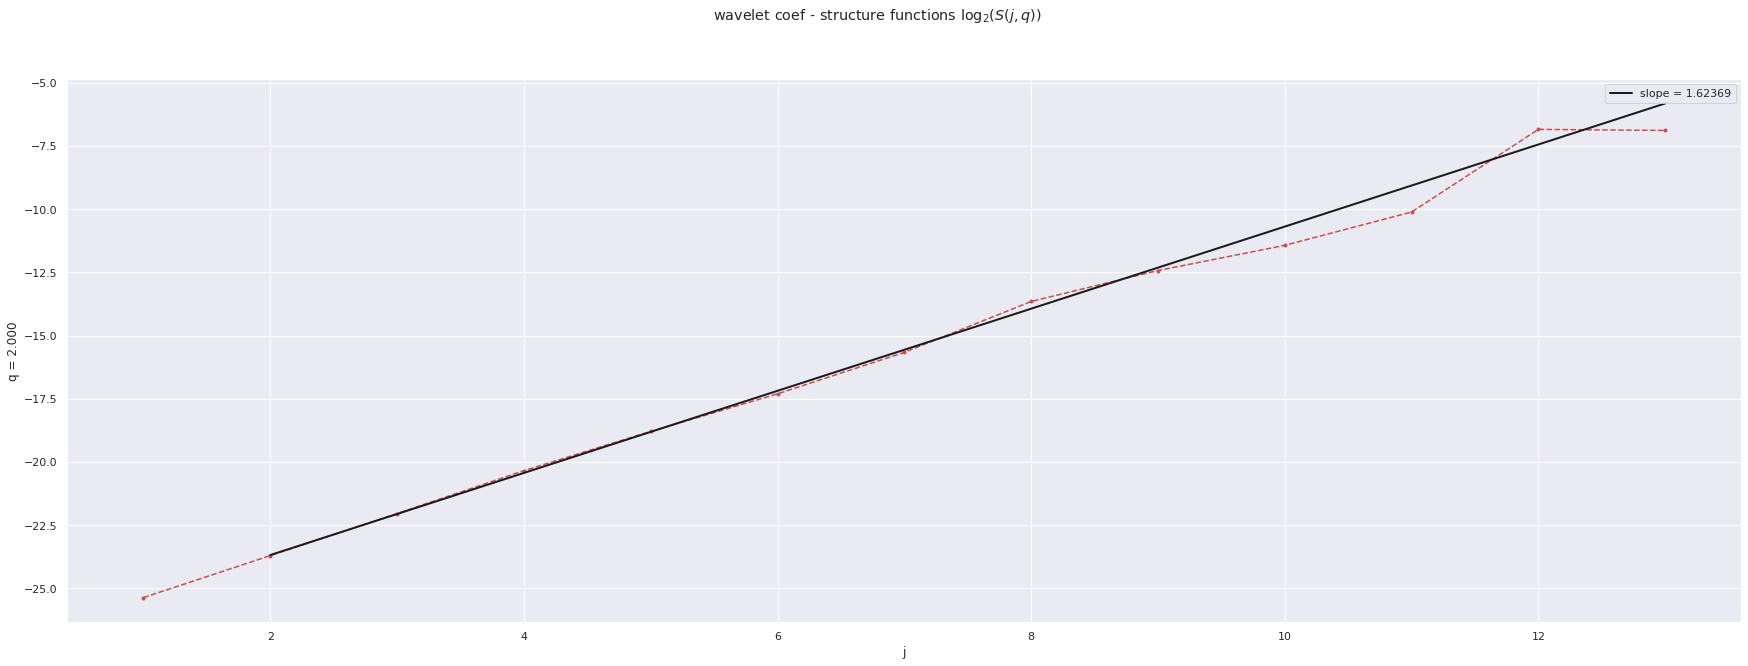

In [25]:
sf.plot(nrow=3)

## Multifractal Analysis

In [26]:
def scale2freq(scale, sfreq):
    return (3/4) * sfreq * (2 ** -scale)


def freq2scale(freq, sfreq):
    return - 2 - np.log2(freq / (3 * sfreq))

**Using wavelet leaders**

In [27]:
dwt, lwt = mfa.mf_analysis_full(X,
    j1=3, j2=16,
    q = build_q_log(1, 10, 20),
    n_cumul=2,
    p_exp=np.inf,
    gamint=1.0
)

/home/md262764/Multifracs/pymultifracs/pymultifracs/wavelet.py:115: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 13
  warnings.warn("Value of j2 is higher than the maximum allowed level. "


In [28]:
dwt.hmin

array([0.644714])

The `lwt` variable shares the same structure as `dwt`

In [29]:
lwt_sf, lwt_cumul, lwt_mfs, hmin = lwt

The `lwt_sf`, `lwt_cumul`, `lwt_mfs` variables defined here share the same structure as the `sf`, `cumul`, and `mfs` variables defined previously

**structure functions**

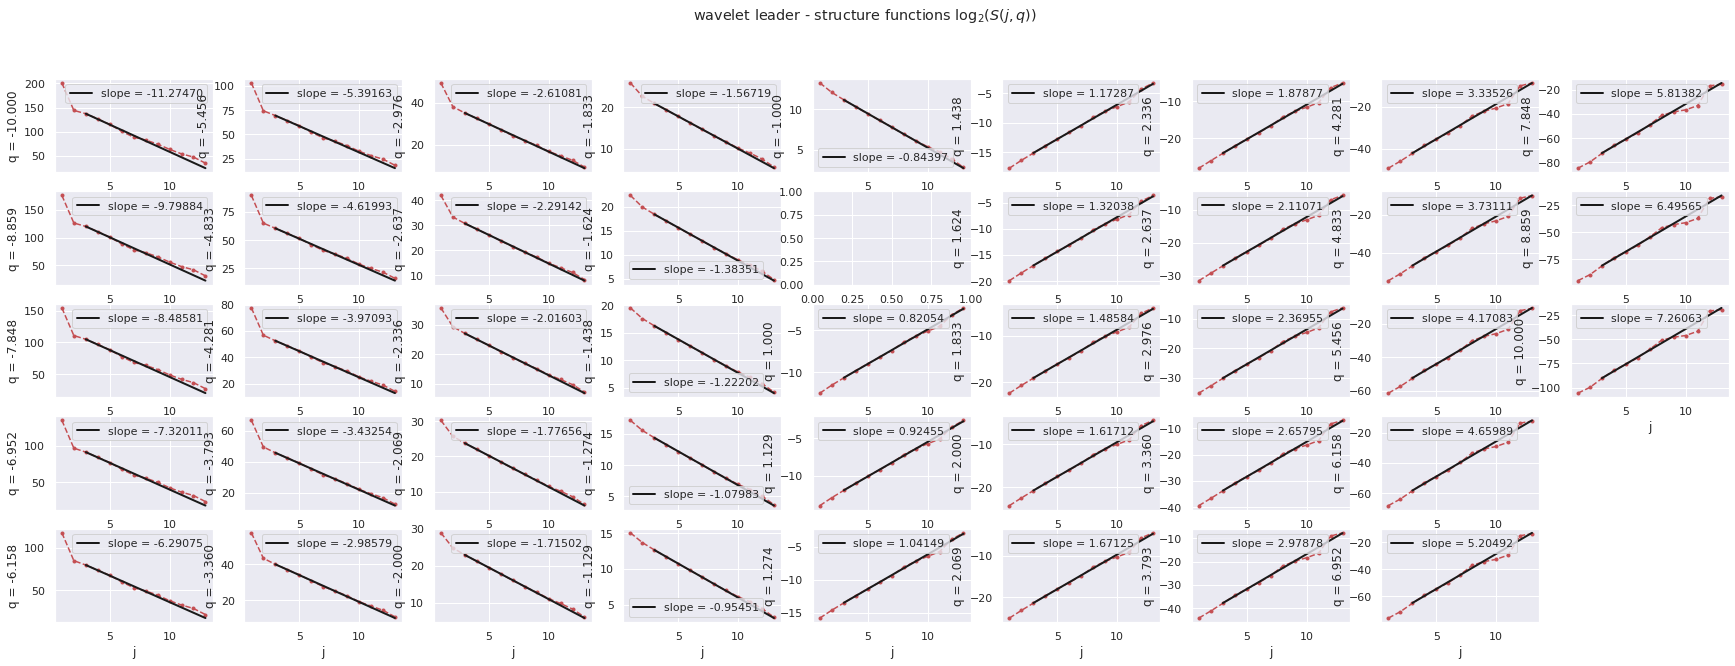

In [30]:
lwt_sf.plot(nrow=5)

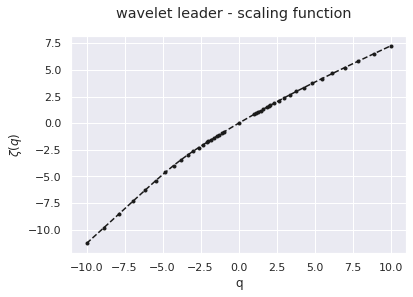

In [31]:
lwt_sf.plot_scaling()

In [32]:
lwt_sf.H

array([-0.19144144])

**cumulants**

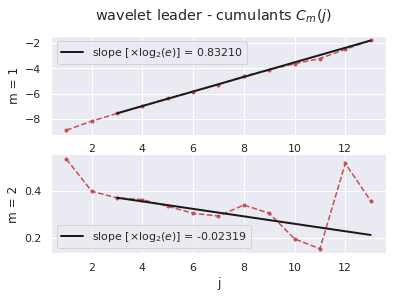

In [33]:
lwt_cumul.plot(nrow=3)

In [34]:
lwt_cumul.log_cumulants

array([[ 0.83209594],
       [-0.0231869 ]])

**multifractal spectrum**

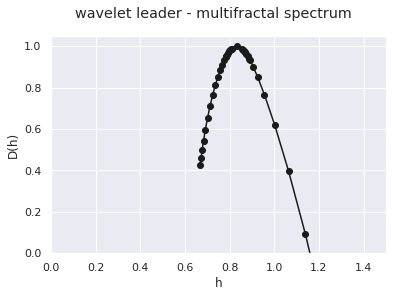

In [35]:
lwt_mfs.plot()

Overlaid with the theoretical spectrum

In [36]:
h = np.linspace(0, 1.5, 30)

c2 = -0.03
c1 = 0.8 - c2
D = 1 - (((h - c1) ** 2) / (2 * abs(c2)))

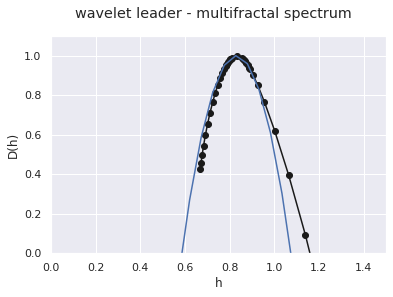

In [37]:
lwt_mfs.plot()

plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.plot(h, D)
plt.show()

**Using p-leaders**

In [38]:
dwt, lwt = mfa.mf_analysis_full(X,
    j1=3, j2=16,
    q = build_q_log(1, 10, 20),
    n_cumul=2,
    p_exp=2,
    gamint=1.0
)

/home/md262764/Multifracs/pymultifracs/pymultifracs/wavelet.py:115: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 13
  warnings.warn("Value of j2 is higher than the maximum allowed level. "


The `lwt` variable shares the same structure as `dwt`

In [39]:
lwt_sf, lwt_cumul, lwt_mfs, hmin = lwt

The `lwt_sf`, `lwt_cumul`, `lwt_mfs` variables defined here share the same structure as the `sf`, `cumul`, and `mfs` variables defined previously

**structure functions**

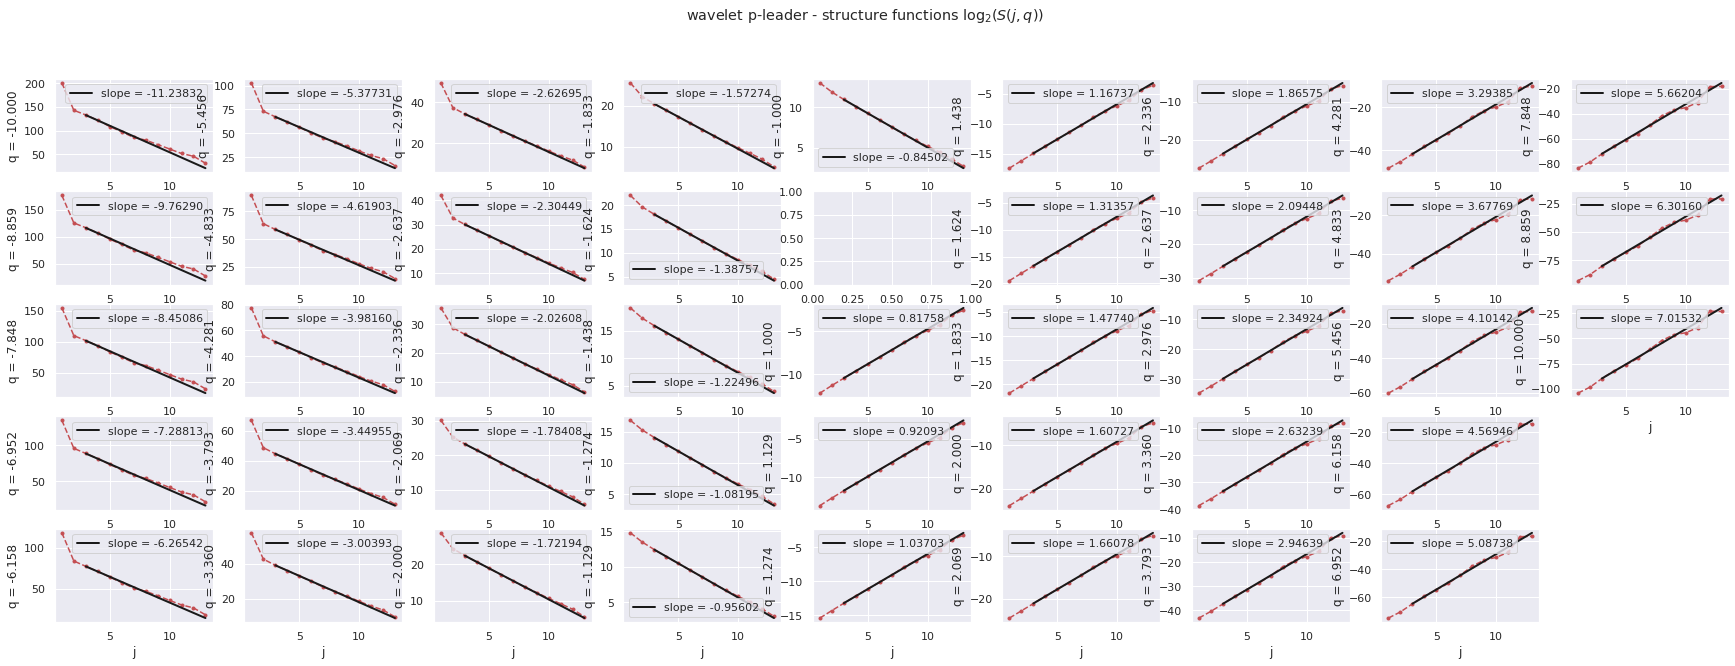

In [40]:
lwt_sf.plot(nrow=5)

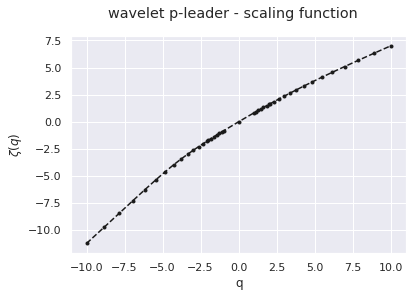

In [41]:
lwt_sf.plot_scaling()

**cumulants**

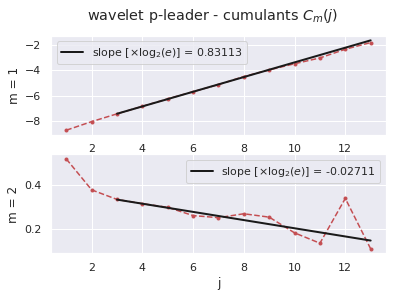

In [42]:
lwt_cumul.plot(nrow=3)

In [43]:
lwt_cumul.log_cumulants

array([[ 0.83113284],
       [-0.02710648]])

**multifractal spectrum**

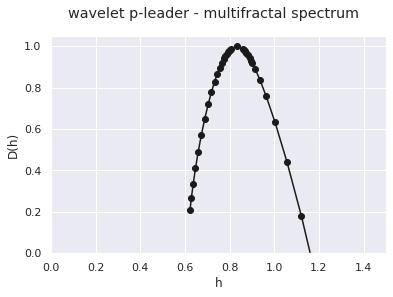

In [44]:
lwt_mfs.plot()

With theoretical spectrum

In [45]:
h = np.linspace(0, 1.5, 30)

c2 = -0.03
c1 = 0.8 - c2
D = 1 - (((h - c1) ** 2) / (2 * abs(c2)))

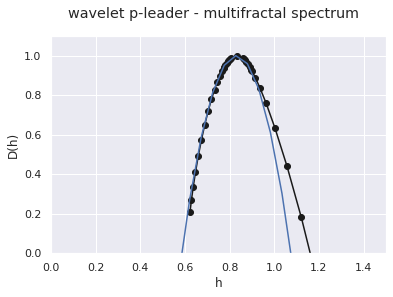

In [46]:
lwt_mfs.plot()

plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.plot(h, D)
plt.show()